In [ ]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import gc
sns.set_style("whitegrid");
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle as pkl
import tqdm as tqdm
from random import choices
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import Ridge

## Standardize using MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#to save it
# with open("train1.pkl", "wb") as f:
#     pkl.dump([X_train,y_train], f)
    
# with open("test1.pkl", "wb") as f:
#     pkl.dump(X_test, f)


#to load it
with open("train_final7.pkl", "rb") as f:
    X_train_data,y_train_data = pkl.load(f)
with open("test_final7.pkl", "rb") as f:
    X_test = pkl.load(f)

# Models Training

In [ ]:
X_train,X_cv,y_train,y_cv = train_test_split(X_train_data, y_train_data,stratify=y_train_data,test_size=0.20)

In [ ]:
print(X_train.shape)
print(X_cv.shape)

(246004, 729)
(61502, 729)


### Logistic regression with hyper parameter tuning

In [ ]:
alpha=[10 ** x for x in range(-5,1)]


cv_score_array=[]
train_score_array=[]

for i in alpha:
    log_clf=SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    log_clf.fit(X_train,y_train)
    log_sig_clf = CalibratedClassifierCV(log_clf, method="sigmoid")
    log_sig_clf.fit(X_train,y_train)
    cv_predict_y = log_sig_clf.predict_proba(X_cv)
    train_predict_y = log_sig_clf.predict_proba(X_train)
    train_score_array.append(roc_auc_score(y_train, train_predict_y[:,1], labels=log_clf.classes_))
    cv_score_array.append(roc_auc_score(y_cv, cv_predict_y[:,1], labels=log_clf.classes_))

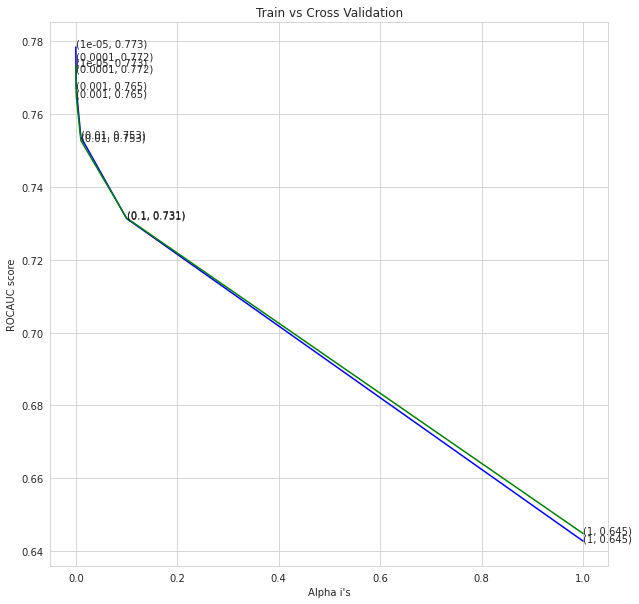

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, train_score_array,c='b')
ax.plot(alpha, cv_score_array,c='g')
for i, txt in enumerate(np.round(cv_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_score_array[i]))
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],train_score_array[i]))
   
ax.grid(b=True)
plt.title("Train vs Cross Validation")
plt.xlabel("Alpha i's")
plt.ylabel("ROCAUC score")
plt.show()

In [ ]:
best_alpha_value=np.argmax(cv_score_array)
log_clf = SGDClassifier(alpha=alpha[best_alpha_value], penalty='l2', loss='log', random_state=42)
log_clf.fit(X_train, y_train)
log_sig_clf = CalibratedClassifierCV(log_clf, method="sigmoid")
log_sig_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                           

In [ ]:
filename = 'log_sig_clf.sav'
pkl.dump(log_sig_clf, open(filename, 'wb'))

In [ ]:
log_sig_clf = pkl.load(open('log_sig_clf.sav', 'rb'))

In [ ]:
predicted_train=log_sig_clf.predict_proba(X_train)
predicted_cv=log_sig_clf.predict_proba(X_cv)

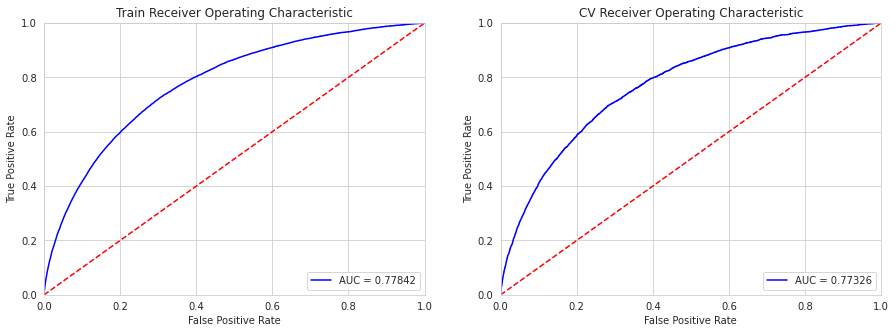

In [ ]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15, 5))

fpr, tpr, threshold = metrics.roc_curve(y_train, predicted_train[:,1])
roc_auc = metrics.auc(fpr, tpr)   
axes[0].title.set_text('Train Receiver Operating Characteristic')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')

fpr, tpr, threshold = metrics.roc_curve(y_cv, predicted_cv[:,1])
roc_auc = metrics.auc(fpr, tpr) 
axes[1].title.set_text('CV Receiver Operating Characteristic')
axes[1].plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [0, 1],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
plt.show()

In [ ]:
test_predictions_log=log_sig_clf.predict_proba(X_test)[:,1]

In [ ]:
predictions = test_predictions_log
submission = app_test[['SK_ID_CURR']].copy()
submission['TARGET'] = predictions.copy()
submission.to_csv('logistic_regression_sub.csv', index = False)

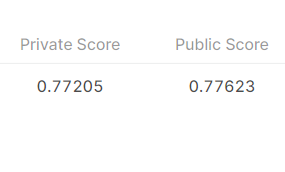

### Linear SVM with hyper parameter tuning

In [ ]:
alpha=[10 ** x for x in range(-4,2)]

cv_score_array=[]
train_score_array=[]

for i in tqdm(alpha):
    svm_clf=SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    svm_clf.fit(X_train,y_train)
    svm_sig_clf = CalibratedClassifierCV(svm_clf, method="sigmoid")
    svm_sig_clf.fit(X_train,y_train)
    cv_predict_y = svm_sig_clf.predict_proba(X_cv)
    train_predict_y = svm_sig_clf.predict_proba(X_train)
    train_score_array.append(roc_auc_score(y_train, train_predict_y[:,1], labels=log_clf.classes_))
    cv_score_array.append(roc_auc_score(y_cv, cv_predict_y[:,1], labels=log_clf.classes_))

100%|██████████| 6/6 [02:58<00:00, 29.74s/it]


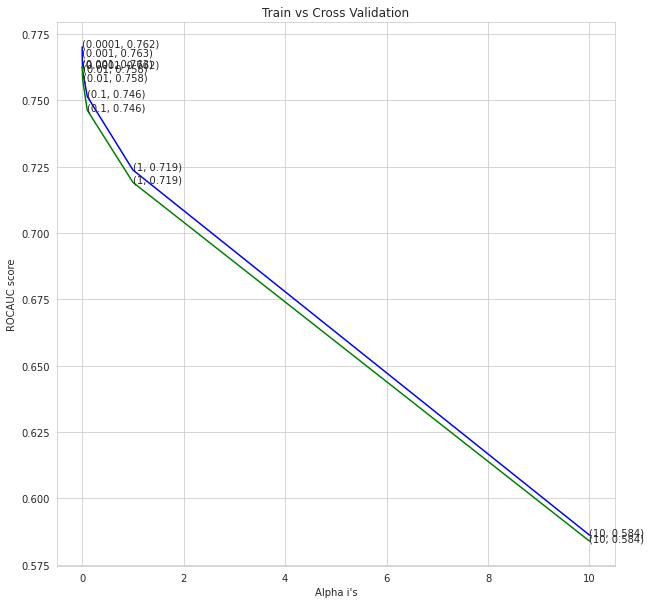

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, train_score_array,c='b')
ax.plot(alpha, cv_score_array,c='g')
for i, txt in enumerate(np.round(cv_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_score_array[i]))
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],train_score_array[i]))
   
ax.grid(b=True)
plt.title("Train vs Cross Validation")
plt.xlabel("Alpha i's")
plt.ylabel("ROCAUC score")
plt.show()

In [ ]:
best_alpha_value=np.argmax(cv_score_array)
svm_clf = SGDClassifier(alpha=alpha[best_alpha_value], penalty='l2', loss='hinge', random_state=42)
svm_clf.fit(X_train, y_train)
svm_sig_clf = CalibratedClassifierCV(svm_clf, method="sigmoid")
svm_sig_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                         

In [ ]:
filename = 'svm_sig_clf.sav'
pkl.dump(svm_sig_clf, open(filename, 'wb'))

In [ ]:
svm_sig_clf = pkl.load(open('svm_sig_clf.sav', 'rb'))

In [ ]:
predicted_train=svm_sig_clf.predict_proba(X_train)
predicted_cv=svm_sig_clf.predict_proba(X_cv)

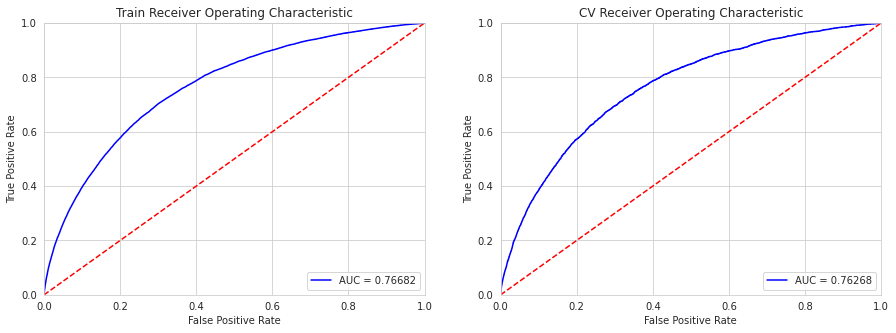

In [ ]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15, 5))

fpr, tpr, threshold = metrics.roc_curve(y_train, predicted_train[:,1])
roc_auc = metrics.auc(fpr, tpr)   
axes[0].title.set_text('Train Receiver Operating Characteristic')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')

fpr, tpr, threshold = metrics.roc_curve(y_cv, predicted_cv[:,1])
roc_auc = metrics.auc(fpr, tpr) 
axes[1].title.set_text('CV Receiver Operating Characteristic')
axes[1].plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [0, 1],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
plt.show()

In [ ]:
svm_predict=svm_sig_clf.predict_proba(X_test)[:,1]

In [ ]:
predictions = svm_predict
submission = test_data[['SK_ID_CURR']].copy()
submission['TARGET'] = predictions.copy()
submission.to_csv('svm_sub.csv', index = False)

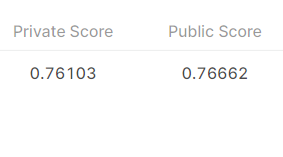

### Random Forest with Hyper parameter tuning

In [ ]:
alpha = [10,50,100,200,500]
cv_log_score_array = []
train_log_score_array=[]
for i in tqdm(alpha):
    rf_clf = RandomForestClassifier(n_estimators=i,max_depth=5,criterion='gini', random_state=42, n_jobs=-1)
    # rf_sig_clf = CalibratedClassifierCV(rf_clf, method="sigmoid")
    rf_clf.fit(X_train,y_train)
    rf_clf_probs_train = rf_clf.predict_proba(X_train)
    rf_clf_probs_cv = rf_clf.predict_proba(X_cv)
    cv_log_score_array.append(roc_auc_score(y_cv, rf_clf_probs_cv[:,1]))
    train_log_score_array.append(roc_auc_score(y_train, rf_clf_probs_train[:,1]))

100%|██████████| 5/5 [17:38<00:00, 211.62s/it]


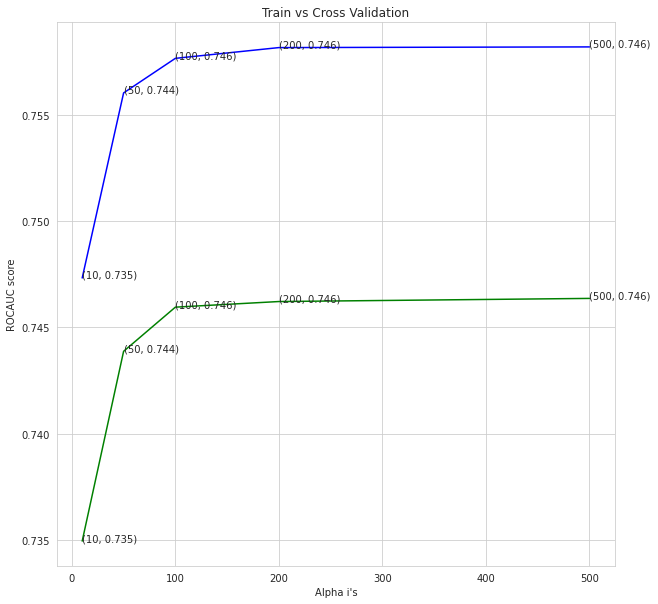

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, train_log_score_array,c='b')
ax.plot(alpha, cv_log_score_array,c='g')
for i, txt in enumerate(np.round(cv_log_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],train_log_score_array[i]))
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_score_array[i]))
ax.grid(b=True)
plt.title("Train vs Cross Validation")
plt.xlabel("Alpha i's")
plt.ylabel("ROCAUC score")
plt.show()

In [ ]:
best_alpha_value=np.argmax(cv_log_score_array)
rf_clf = RandomForestClassifier(n_estimators=alpha[best_alpha_value],max_depth=5, criterion='gini', random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
# rf_sig_clf = CalibratedClassifierCV(rf_clf, method="sigmoid")
# rf_sig_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
filename = 'rf_clf.sav'
pkl.dump(rf_clf, open(filename, 'wb'))

In [ ]:
rf_clf = pkl.load(open('rf_clf.sav', 'rb'))

In [ ]:
predicted_train=rf_clf.predict_proba(X_train)
predicted_cv=rf_clf.predict_proba(X_cv)

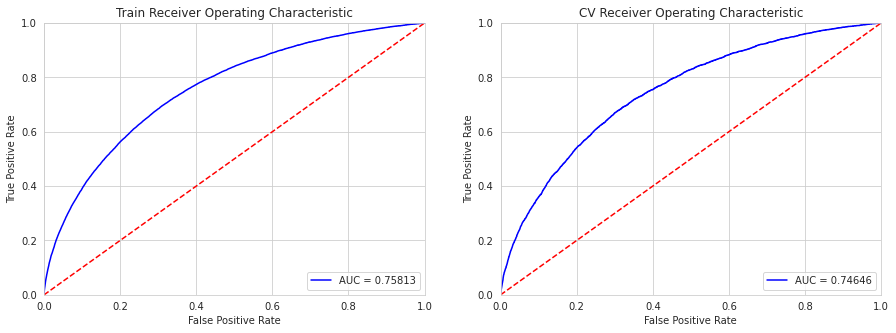

In [ ]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15, 5))

fpr, tpr, threshold = metrics.roc_curve(y_train, predicted_train[:,1])
roc_auc = metrics.auc(fpr, tpr)   
axes[0].title.set_text('Train Receiver Operating Characteristic')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')

fpr, tpr, threshold = metrics.roc_curve(y_cv, predicted_cv[:,1])
roc_auc = metrics.auc(fpr, tpr) 
axes[1].title.set_text('CV Receiver Operating Characteristic')
axes[1].plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [0, 1],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
plt.show()

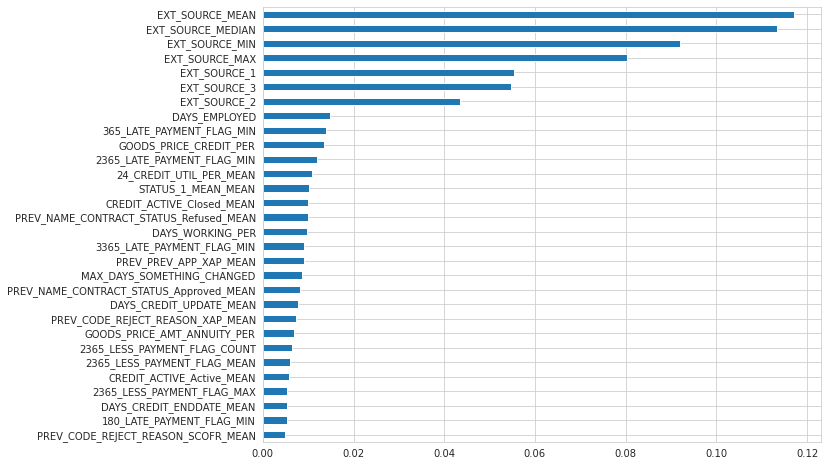

In [ ]:
train_column = pkl.load(open('train_column (5).pkl', 'rb'))
plt.figure(figsize=(10,8))
feat_importances = pd.Series(rf_clf.feature_importances_,index=train_column)
feat_importances.nlargest(30).sort_values().plot(kind='barh')

In [ ]:
rf_predict=rf_clf.predict_proba(X_test)[:,1]

In [ ]:
predictions = rf_predict
submission = app_test[['SK_ID_CURR']].copy()
submission['TARGET'] = predictions.copy()
submission.to_csv('rf_sub.csv', index = False)

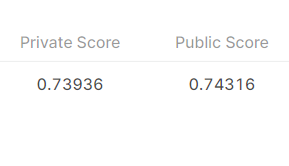

### Hyperparameter Tuning Bayesian  Optmization for LGBM

In [ ]:
def lgbm_evaluate(**params):
    
    '''
    method for optimization of auc score
    '''
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    # params['n_estimators'] = int(params['n_estimators'])
            
    clf = LGBMClassifier(**params,n_estimators=10000,nthread = -1,random_state=42)

    folds = KFold(n_splits = 2, shuffle = True, random_state = 42)
    
    test_pred_proba = np.zeros(y_train.shape[0])
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):
        train_x, train_y = X_train[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[valid_idx], y_train.iloc[valid_idx]
    

        clf.fit(train_x, train_y, 
             eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = False, early_stopping_rounds = 100)
        
        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]

    return roc_auc_score(y_train, test_pred_proba)

In [ ]:
params = {'colsample_bytree': (0.8, 1), #the fraction of columns to be randomly samples
          'learning_rate': (.01, .02), 
          'num_leaves': (30, 40),  #max leaf nodes
          # 'n_estimators' :(100,10000),  #number of trees
          'subsample': (0.8, 1),  #fraction of observations to be randomly samples for each tree.
          'max_depth': (5, 10),  #maximum depth of a tree
          'reg_alpha': (.03, .05),  #L1 regularization
          'reg_lambda': (.06, .08), #L2 regularization
         }

bo = BayesianOptimization(lgbm_evaluate, params)
bo.maximize(init_points = 5, n_iter = 5) 
#init_points exploration points
#n_iter exploitation(how deep to exploit those points)

|   iter    |  target   | colsam... | learni... | max_depth | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7865   |  0.8857   |  0.01315  |  9.93     |  30.8     |  0.04319  |  0.06618  |  0.8575   |
|  2        |  0.787    |  0.9239   |  0.01746  |  5.135    |  38.62    |  0.04628  |  0.06276  |  0.8502   |
|  3        |  0.7869   |  0.9675   |  0.01869  |  5.438    |  35.44    |  0.03947  |  0.06077  |  0.9019   |
|  4        |  0.7867   |  0.8925   |  0.01698  |  7.917    |  38.01    |  0.03616  |  0.07496  |  0.9276   |
|  5        |  0.786    |  0.8039   |  0.01848  |  9.625    |  34.31    |  0.04365  |  0.06745  |  0.9954   |
|  6        |  0.7873   |  0.8697   |  0.01311  |  5.038    |  39.93    |  0.04531  |  0.06782  |  0.9233   |
|  7        |  0.7871   |  0.95     |  0.01542  |  5.011    |  30.04    |  0.03552  |  0.07774  |  0.9014   |
|  8      

In [ ]:
best_params=bo.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params

{'colsample_bytree': 0.8572534238022248,
 'learning_rate': 0.01104962968329767,
 'max_depth': 5,
 'num_leaves': 39,
 'reg_alpha': 0.038140915703304204,
 'reg_lambda': 0.07063325958022158,
 'subsample': 0.9697952083993573}

In [ ]:
#best params
{'colsample_bytree': 0.8300561776673268,
 'learning_rate': 0.011066498647964494,
 'max_depth': 5,
 'n_estimators': 9998.426865043843,
 'num_leaves': 39,
 'reg_alpha': 0.043643178359084406,
 'reg_lambda': 0.07466129312465195,
 'subsample': 0.9480626572302944}

In [ ]:
{'colsample_bytree': 0.8572534238022248,
 'learning_rate': 0.01104962968329767,
 'max_depth': 5,
 'num_leaves': 39,
 'reg_alpha': 0.038140915703304204,
 'reg_lambda': 0.07063325958022158,
 'subsample': 0.9697952083993573}

In [1]:
folds = KFold(n_splits= 10, shuffle=False, random_state=42)

train_pred_proba = np.zeros(y_train_data.shape[0])
test_pred_proba = np.zeros(len(X_test_data))

lgbm_clf_list=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train_data,y_train_data)):
    
    train_x, train_y = X_train_data[train_idx], y_train_data.iloc[train_idx]
    valid_x, valid_y = X_train_data[valid_idx], y_train_data.iloc[valid_idx]
        
    lgbm_clf = LGBMClassifier(colsample_bytree=0.8572534238022248,
                              learning_rate= 0.01104962968329767,
                              max_depth=5,
                              n_estimators=10000,
                              num_leaves=39,
                              nthread =-1,
                              reg_alpha= 0.038140915703304204,
                              reg_lambda= 0.07063325958022158,
                              subsample=0.9697952083993573,
                              random_state=42)

    lgbm_clf.fit(train_x,train_y,eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', verbose = False, early_stopping_rounds = 100)

    lgbm_clf_list.append(lgbm_clf)  
    
    train_pred_proba[valid_idx] = lgbm_clf.predict_proba(valid_x, num_iteration=lgbm_clf.best_iteration_)[:, 1]
    test_pred_proba += lgbm_clf.predict_proba(X_test_data, num_iteration=lgbm_clf.best_iteration_)[:, 1] / folds.n_splits

    
    
del train_x, train_y, valid_x, valid_y
gc.collect()

In [ ]:
with open("lgbm_clf_list.pkl", "wb") as f:
    pkl.dump(lgbm_clf_list, f)

In [ ]:
with open("test_pred_proba_1_1.pkl", "wb") as f:
    pkl.dump(test_pred_proba, f)
with open("train_pred_proba_1_1.pkl", "wb") as f:
    pkl.dump(test_pred_proba, f)

In [ ]:
filename = 'lgbm_clf.sav'
pkl.dump(lgbm_clf, open(filename, 'wb'))

In [ ]:
lgbm_clf = pkl.load(open('lgbm_clf.sav', 'rb'))

In [ ]:
predicted_train=lgbm_clf.predict_proba(X_train_data)
predicted_cv=lgbm_clf.predict_proba(X_cv)

Text(0.5, 0, 'False Positive Rate')

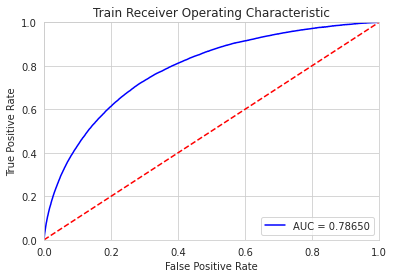

In [ ]:
fig,axes=plt.subplots()

fpr, tpr, threshold = metrics.roc_curve(y_train_data,train_pred_proba)
roc_auc = metrics.auc(fpr, tpr)   
axes.title.set_text('Train Receiver Operating Characteristic')
axes.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
axes.legend(loc = 'lower right')
axes.plot([0, 1], [0, 1],'r--')
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
axes.set_ylabel('True Positive Rate')
axes.set_xlabel('False Positive Rate')


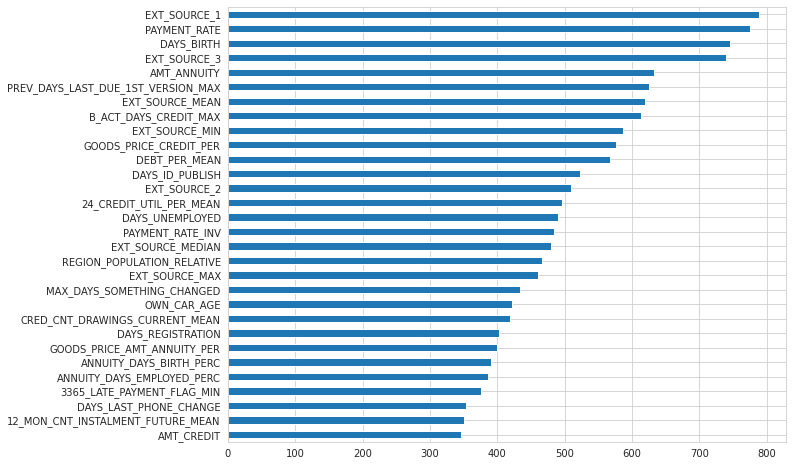

In [ ]:
train_column = pkl.load(open('train_column (5).pkl', 'rb'))
plt.figure(figsize=(10,8))
feat_importances = pd.Series(lgbm_clf.feature_importances_, index=train_column)
feat_importances.nlargest(30).sort_values().plot(kind='barh')

In [ ]:
predictions = test_pred_proba
submission = app_test[['SK_ID_CURR']].copy()
submission['TARGET'] = predictions.copy()
submission.to_csv('lgbm_sub.csv', index = False)

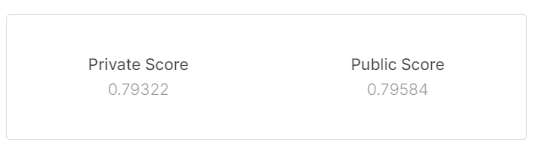

### Custom Model Implementation

In [ ]:
X_train,cus_X_test,y_train,cus_y_test = train_test_split(X_train_data,y_train_data,stratify=y_train_data,test_size=0.20)

In [ ]:
def custom_ensemble(X_train,y_train,X_test, n_estimators,base_model,meta_model): 
    '''
    custom ensemble model implementation 
    '''
    
    X_train_d1,X_train_d2,y_train_d1,y_train_d2 = train_test_split(X_train,y_train,stratify=y_train,test_size=0.50)

    y_train_d1.reset_index(drop=True,inplace=True)

    
    parent_array_0=list(y_train_d1[y_train_d1==0].index) #index of target 0
    parent_array_1=list(y_train_d1[y_train_d1==1].index) #index of target 1
    
    k_samples=n_estimators #no of base 
    
    k_size1=int(len(parent_array_0)*0.2) 
    k_size2=int(len(parent_array_1)*1) 

    X_samples_k=[]
    y_samples_k=[]
    for i in range(0,k_samples):
        sample_no_0=choices(parent_array_0, k=k_size1)  #sample 20% of target 0 
        sample_no_1=choices(parent_array_1, k=k_size2)  #take 100% 0f target 1
        sample_no=sample_no_0+sample_no_1
        X_samples_k.append(X_train_d1[sample_no])
        y_samples_k.append(y_train_d1.iloc[sample_no])
        
    # train k models
    trained_models=[]
    d_clf=base_model
    
    #fit base model on newly created samples
    for i in range(0,k_samples):
        d_clf.fit(X_samples_k[i],y_samples_k[i])
        trained_models.append(d_clf)
    
    del X_samples_k,y_samples_k  
    gc.collect()
        
    #predict k models on X_train_d2
    k_predictions=[]
    for i in range(0,k_samples):
        k_predictions.append(trained_models[i].predict_proba(X_train_d2)[:,1])
    

    k_predictions=np.array(k_predictions)
    k_predictions=k_predictions.transpose()
    
    #train on k_predictions of X_train_d2
    d_clf_meta=meta_model
    
    d_clf_meta.fit(k_predictions,y_train_d2)
    
    #prediction on X_test
    k_predictions_test=[]
    for i in range(0,k_samples):
        k_predictions_test.append(trained_models[i].predict_proba(X_test)[:,1])
    
    k_predictions_test=np.array(k_predictions_test)
    k_predictions_test=k_predictions_test.transpose()
    
#     print(k_predictions)
        
    test_predictions=d_clf_meta.predict_proba(k_predictions_test)[:,1]
    
    del X_train_d1,X_train_d2,y_train_d1,y_train_d2
    
    gc.collect()
    
    return test_predictions
    

In [ ]:
def ensemble_evaluate(**params):
         
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])   

    b_model=SGDClassifier(alpha=0.0001,class_weight='balanced', penalty='l2', loss='log',random_state=42,max_iter=3000)
    m_model=LGBMClassifier(**params,class_weight='balanced',nthread = -1)
    test_predictions=custom_ensemble(X_train,y_train,cus_X_test,10,b_model,m_model)

    return roc_auc_score(cus_y_test,test_predictions)

In [ ]:
params = { #the fraction of columns to be randomly samples
          'learning_rate': (.01, .001), 
          'num_leaves': (30, 40),  #max leaf nodes
          'n_estimators' :(100,10000),  #number of trees
          'subsample': (0.8, 1),  #fraction of observations to be randomly samples for each tree.
          'max_depth': (5, 40),  #maximum depth of a tree
          'reg_alpha': (.03, .05),  #L1 regularization
          'reg_lambda': (.06, .08), #L2 regularization
         }

bo = BayesianOptimization(ensemble_evaluate, params)
bo.maximize(init_points = 5, n_iter = 5) # init_points exploration points and #n_iter exploitation(how deep to exploit those points)

In [ ]:
bo.max['params']

In [ ]:
#params with max auc score
params={'learning_rate': 0.009034393825419894,
 'max_depth': 5.606675939537618,
 'n_estimators': 9506.798509761635,
 'num_leaves': 34.27752187289281,
 'reg_alpha': 0.049769333554952604,
 'reg_lambda': 0.06517214704565098,
 'subsample': 0.8651650623376512}

params['num_leaves'] = int(params['num_leaves'])
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])  

b_model=SGDClassifier(alpha=0.0001,class_weight='balanced', penalty='l2', loss='log',random_state=42,max_iter=3000)
m_model=LGBMClassifier(**params,class_weight='balanced',nthread = -1)
test_predictions=custom_ensemble(X_train,y_train,cus_X_test,10,b_model,m_model)

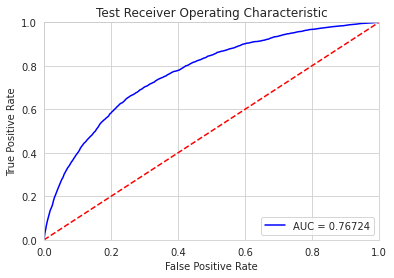

In [ ]:
fig,axes=plt.subplots(nrows=1,ncols=1)
fpr, tpr, threshold = metrics.roc_curve(cus_y_test,test_predictions)
roc_auc = metrics.auc(fpr, tpr)   
axes.title.set_text('Test Receiver Operating Characteristic')
axes.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
axes.legend(loc = 'lower right')
axes.plot([0, 1], [0, 1],'r--')
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
axes.set_ylabel('True Positive Rate')
axes.set_xlabel('False Positive Rate')
plt.show()

In [ ]:
#best_params
params={'learning_rate': 0.009034393825419894,
 'max_depth': 5.606675939537618,
 'n_estimators': 9506.798509761635,
 'num_leaves': 34.27752187289281,
 'reg_alpha': 0.049769333554952604,
 'reg_lambda': 0.06517214704565098,
 'subsample': 0.8651650623376512}

params['num_leaves'] = int(params['num_leaves'])
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])  


b_model=SGDClassifier(alpha=0.0001,class_weight='balanced', penalty='l2', loss='log',random_state=42,max_iter=3000)
m_model=LGBMClassifier(**params,class_weight='balanced',nthread = -1)
predictions =custom_ensemble(X_train,y_train,X_test,30,b_model,m_model)

In [ ]:
predictions = predictions
submission = app_test[['SK_ID_CURR']].copy()
submission['TARGET']=predictions.copy()
submission.to_csv('custom_ensemble_sub.csv', index = False)

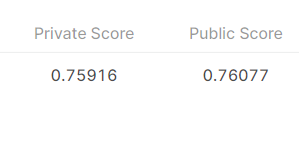

# Summary

In [ ]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = "Model Comparision "
ptable.field_names = ["Model",'Train ROCAUC score','Validataion ROCAUC score','Private score','Public score']
ptable.add_row(["Logistic Regression","0.77842","0.77326","0.77205","0.77623"])
ptable.add_row(["SVM","0.75813","0.74646","0.76103","0.76662"])
ptable.add_row(["Random Forest","0.75813","0.74646","0.73936","0.74316"])
ptable.add_row(["LGBMClassifier","0.79234","-","0.79322","0.79584"])
ptable.add_row(["Custom Ensemble","-","0.76724","0.75916",'0.76077'])
print(ptable)

+----------------------------------------------------------------------------------------------------+
|                                         Model Comparision                                          |
+---------------------+--------------------+--------------------------+---------------+--------------+
|        Model        | Train ROCAUC score | Validataion ROCAUC score | Private score | Public score |
+---------------------+--------------------+--------------------------+---------------+--------------+
| Logistic Regression |      0.77842       |         0.77326          |    0.77205    |   0.77623    |
|         SVM         |      0.75813       |         0.74646          |    0.76103    |   0.76662    |
|    Random Forest    |      0.75813       |         0.74646          |    0.73936    |   0.74316    |
|    LGBMClassifier   |      0.79234       |            -             |    0.79322    |   0.79584    |
|   Custom Ensemble   |         -          |         0.76724          |  